In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
df = pd.read_json('../data/car_log_20250504_122032_small_track.jsonl', lines=True)
df.head(10)

,timestamp,speed_mps,yaw,steering_angle,latitude,longitude,altitude
0,86837,2.758966,0.0,0.0,55.944507,-3.186358,4.332708
1,86997,2.758966,0.0,0.0,55.944489,-3.186385,-1.372084
2,87197,2.758966,0.0,0.0,55.944489,-3.186380,5.013191
3,87397,2.758966,0.0,0.0,55.944485,-3.186362,2.719111
4,87597,2.758966,0.0,0.0,55.944502,-3.186398,5.964380
5,87797,2.758966,0.0,0.0,55.944491,-3.186351,2.874794
6,87997,2.758966,0.0,0.0,55.944513,-3.186342,0.540781
7,88197,2.758966,0.0,0.0,55.944502,-3.186275,4.847608
8,88397,2.758966,0.0,0.0,55.944484,-3.186301,-1.813969
9,88597,2.758966,0.0,0.1,55.944492,-3.186298,0.067742


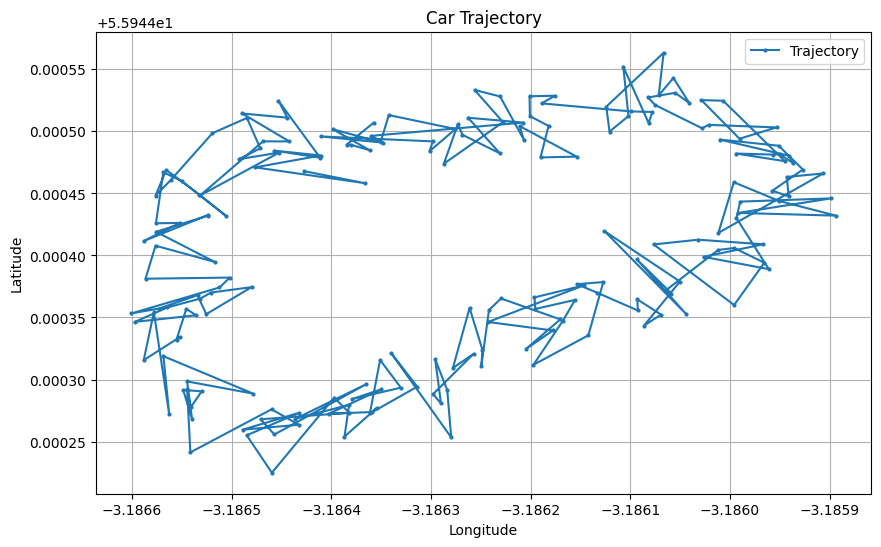

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(df['longitude'], df['latitude'], marker='o', markersize=2, linestyle='-', label='Trajectory')
plt.title('Car Trajectory')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid()
plt.show()

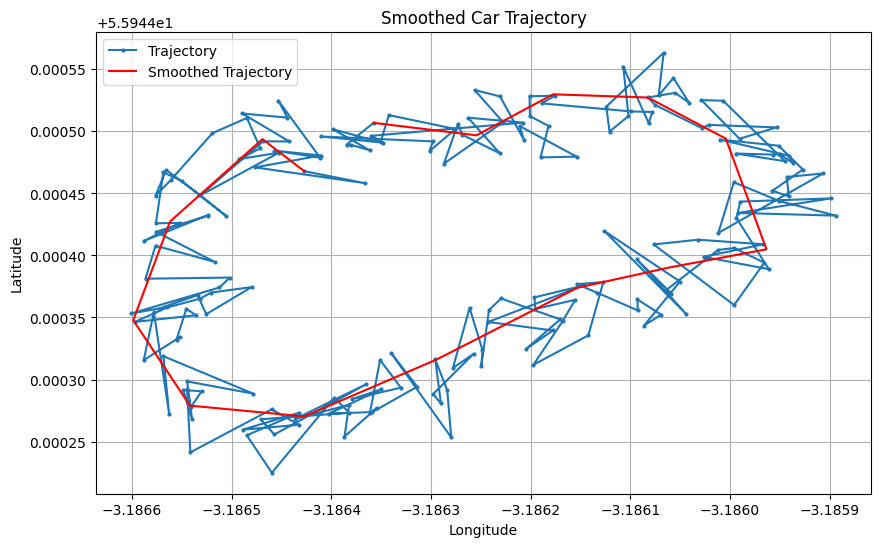

In [28]:
from scipy.interpolate import make_interp_spline
import numpy as np

# Extract the data
timestamps = df['timestamp']
latitudes = df['latitude']
longitudes = df['longitude']

# Create a smoother timestamp range
smooth_timestamps = np.linspace(timestamps.min(), timestamps.max(), 15)

# Perform spline interpolation for latitude and longitude
lat_spline = make_interp_spline(timestamps, latitudes, k=3)
lon_spline = make_interp_spline(timestamps, longitudes, k=3)

smooth_latitudes = lat_spline(smooth_timestamps)
smooth_longitudes = lon_spline(smooth_timestamps)

# Plot the smoothed trajectory
plt.figure(figsize=(10, 6))
plt.plot(df['longitude'], df['latitude'], marker='o', markersize=2, linestyle='-', label='Trajectory')
plt.plot(smooth_longitudes, smooth_latitudes, label='Smoothed Trajectory', color='red')
plt.title('Smoothed Car Trajectory')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid()
plt.show()

In [32]:
# Create a dataset of waypoints and steering angles
waypoints_dataset = df[['latitude', 'longitude', 'steering_angle']]

# Save the dataset to a CSV file for training
waypoints_dataset.to_csv('waypoints_dataset.csv', index=False)

# Display the first few rows of the dataset
waypoints_dataset.head()

,latitude,longitude,steering_angle
0,55.944507,-3.186358,0.0
1,55.944489,-3.186385,0.0
2,55.944489,-3.186380,0.0
3,55.944485,-3.186362,0.0
4,55.944502,-3.186398,0.0
